In [1]:
from __future__ import print_function

import os
import argparse
import socket
import time
import sys

import torch
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from util import adjust_learning_rate, accuracy, AverageMeter
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
print(torch.__version__)

1.8.1+cu111


In [3]:
parser = argparse.ArgumentParser('argument for training')

parser.add_argument('--eval_freq', type=int, default=10, help='meta-eval frequency')
parser.add_argument('--print_freq', type=int, default=100, help='print frequency')
parser.add_argument('--tb_freq', type=int, default=500, help='tb frequency')
parser.add_argument('--save_freq', type=int, default=10, help='save frequency')
parser.add_argument('--batch_size', type=int, default=4, help='batch_size')
parser.add_argument('--num_workers', type=int, default=8, help='num of workers to use')
parser.add_argument('--epochs', type=int, default=200, help='number of training epochs')

# optimization
parser.add_argument('--learning_rate', type=float, default=0.0001, help='learning rate')
parser.add_argument('--lr_decay_epochs', type=str, default='60,80', help='where to decay lr, can be a list')
parser.add_argument('--lr_decay_rate', type=float, default=0.1, help='decay rate for learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='weight decay')
parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--adam', action='store_true', help='use adam optimizer')

# dataset
parser.add_argument('--model', type=str, default='resnet50')

# cosine annealing
parser.add_argument('--cosine', action='store_true', help='using cosine annealing')

# specify folder
parser.add_argument('--model_path', type=str, default='', help='path to save model')
parser.add_argument('--tb_path', type=str, default='', help='path to tensorboard')
parser.add_argument('--data_root', type=str, default='', help='path to data root')

opt = parser.parse_args(args=[])

In [4]:
iterations = opt.lr_decay_epochs.split(',')
opt.lr_decay_epochs = list([])
for it in iterations:
    opt.lr_decay_epochs.append(int(it))

opt.n_gpu = torch.cuda.device_count()

In [5]:
# get test datasets
test_transforms_option = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
                ])
test_datasets = torchvision.datasets.ImageFolder(root="../../dataset/ours_style4_set/texture_svhn_ood_test", transform = test_transforms_option)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 256, shuffle=False, num_workers = 4)

In [6]:
# model
opt.n_class = 2

print(f'We use {opt.model}')
model = resnet50(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, opt.n_class)

model.load_state_dict(torch.load('../checkpoint_0302/texture_style4_best.pth'))

We use resnet50


<All keys matched successfully>

In [7]:
for i in range(len(test_datasets.classes)) :
    print(f'class {i} : {test_datasets.classes[i]} ')
    
# (원래 클래스의 갯수) + 1 개의 클래스가 나오는게 맞음

class 0 : airplane 
class 1 : airplane_style4 
class 2 : automobile 
class 3 : automobile_style4 
class 4 : bird 
class 5 : bird_style4 
class 6 : cat 
class 7 : cat_style4 
class 8 : deer 
class 9 : deer_style4 
class 10 : dog 
class 11 : dog_style4 
class 12 : frog 
class 13 : frog_style4 
class 14 : horse 
class 15 : horse_style4 
class 16 : ship 
class 17 : ship_style4 
class 18 : svhn_test_output 
class 19 : truck 
class 20 : truck_style4 


In [8]:
def test(val_loader, model, threshold):
    ood_logit_list, iod_logit_list = list(), list()
    model.eval()
    
    rejection_all_count = 0
    rejection_correct_count = 0
    
    closed_all_count = 0
    closed_correct_count = 0
    
    new_target = list()
    all_prob = list()

    with torch.no_grad():
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            pred = output.argmax(dim=1) # .view(output.shape)
            
            tmp_prob_list = list()
            for i in range(len(output)) :
                prob = output[i][pred[i].item()]
                tmp_prob_list.append(prob)
            
            for i in range(len(target)) :
                all_prob.append(tmp_prob_list[i])
                if target[i] == 18 :
                    rejection_all_count += 1
                    new_target.append(0)
                    ood_logit_list.append(tmp_prob_list[i])

                else :
                    closed_all_count += 1
                    new_target.append(1)
                    iod_logit_list.append(tmp_prob_list[i])
            
            # Threshold로 Rejection하기
            for i in range(len(tmp_prob_list)) :
                if tmp_prob_list[i] < threshold :
                    # reject
                    # rejection set이 reject되는 갯수 카운드
                    if target[i] == 18 :
                        rejection_correct_count += 1
                else :
                    # not reject
                    # closed set이 not reject되는 갯수 카운트
                    if target[i] != 18 :
                        closed_correct_count += 1
                    
            
        # metric option1 계산
        rejection_acc = rejection_correct_count/rejection_all_count
        closed_acc = closed_correct_count/closed_all_count
        
        # metric option2 계산
        auc = roc_auc_score(np.array(new_target), np.array(all_prob), multi_class='ovr') # (target, prob)
            
            
    return ood_logit_list, iod_logit_list, rejection_acc, closed_acc, auc

In [9]:
model = model.cuda()

In [29]:
def get_threshold(test_loader, model) :
    
    # get test dataset logit values
    test_value_logits_list = list()
    
    with torch.no_grad():
        for idx, (input, target) in enumerate(test_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            pred = output.argmax(dim=1) # .view(output.shape)
            
            for i in range(len(output)) :
                prob = output[i][pred[i].item()].item()
                test_value_logits_list.append(prob)
            
    
    # compute threshold value
    mean_threshold = sum(test_value_logits_list)/len(test_value_logits_list)
    threshold_3q = np.percentile(np.array(test_value_logits_list), 75)
    
    return mean_threshold

In [30]:
threshold = get_threshold(test_loader, model)

In [31]:
print(threshold) ## check threshold

4.73835656634283


In [32]:
ood_logit_list, iod_logit_list, rejection_acc, closed_acc, auc = test(test_loader, model, threshold)

print('Rejection Acc : ', rejection_acc)
print('Closed set Acc :', closed_acc)
print('AUROC : ', auc)

Rejection Acc :  0.49634202103337904
Closed set Acc : 0.6367692307692308
AUROC :  0.6111319451772126


In [110]:
for i in range(len(ood_logit_list)) :
    ood_logit_list[i] = ood_logit_list[i].item()

for i in range(len(iod_logit_list)) :
    iod_logit_list[i] = iod_logit_list[i].item()

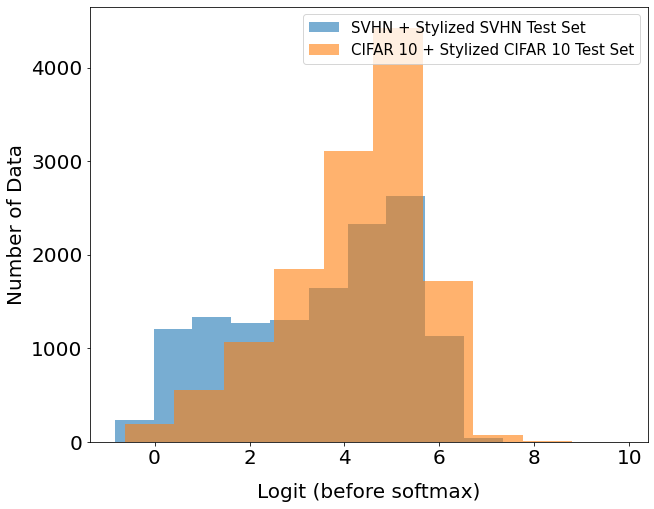

In [111]:
# prob 기준으로 hist 그려보기

params = {'legend.fontsize': 15}
plt.rcParams.update(params)


hist_df = pd.DataFrame({
    'ood_prob': ood_logit_list
})

plt.figure(figsize=(10,8))
plt.hist(hist_df['ood_prob'], label = 'SVHN + Stylized SVHN Test Set', alpha = 0.6) # , color='forestgreen'
plt.xlabel('Logit (before softmax)', fontsize=20, labelpad=15)
plt.xticks(fontsize=20)
plt.ylabel('Number of Data', fontsize=20, labelpad=5)
plt.yticks(fontsize=20)


# 3; open set 
hist_df = pd.DataFrame({
    'iod_prob':iod_logit_list,
})

plt.hist(hist_df['iod_prob'], label = 'CIFAR 10 + Stylized CIFAR 10 Test Set', alpha = 0.6)


plt.legend(loc='best')
plt.show()